### Notebook to analyse *.nc files (with single variables) 

In [2]:
#TODO: extend to multiple variables 

# Imports
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
from iris.util import rolling_window
from ruamel import yaml
from tqdm import tqdm
from ruamel.yaml import ruamel
import warnings

Utilizing 
https://scitools.org.uk/iris/docs/latest/

#### Data import

In [3]:
# test for multi model execution
# just data from one model is used, TODO: generalization
population_weighted = 'ISIMIP3b-MPI-ESM-1-2-HR-population_weighted'
data_dictionary = {}
data_dictionary [population_weighted,'historical']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200325_population/data_historical_complete.yml'
data_dictionary [population_weighted,'ssp126']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200325_population/data_ssp126_complete.yml'
data_dictionary [population_weighted,'ssp585']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200325_population/data_ssp585_complete.yml'

# 
data_dictionary_unweighted = {}
unweighted_data = 'ISIMIP3b-MPI-ESM-1-2-HR'
data_dictionary_unweighted [unweighted_data,'historical']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/historical/output/data_mpi-esm1-2-hr.yml'
data_dictionary_unweighted [unweighted_data,'ssp126']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output/data_mpi-esm1-2-hr.yml'
data_dictionary_unweighted [unweighted_data,'ssp585']= '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp585/output/data_mpi-esm1-2-hr.yml'

# generate dictionary of  data [model,scenario]



# get all keys from dictionary
data_keys = data_dictionary.keys()
filepaths = {}
for i_key in data_keys:
    with open(data_dictionary[i_key], 'r') as stream:
            try:
                filepaths[i_key] = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
print(filepaths)

# get all keys from dictionary
data_unweighted_keys = data_dictionary_unweighted.keys()
filepaths_unweighted = {}
for i_key in data_unweighted_keys:
    with open(data_dictionary_unweighted[i_key], 'r') as stream:
            try:
                filepaths_unweighted[i_key] = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
print(filepaths_unweighted)

{('ISIMIP3b-MPI-ESM-1-2-HR-population_weighted', 'historical'): ['/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_18501850_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_18511860_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_18611870_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_18711880_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_18811890_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_18911900_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_historical_19011910_weighted.nc', '/p/tmp/quante//snow_simulation_data/isimip3b/20200325_population/output_mpi-esm1-2-hr_h

### Data preparation

In [12]:
# load data
# function to filter for specific variables

def filter_cube (cube,variablename):
    return cube.extract(variablename)
   

    
# constrain cubelists

def latitude_constraint(latitude,cube):
    # restrict on latitudes above northern tropic
    latitudeConstraint = iris.Constraint(latitude=lambda v: latitude <= v)
    return cube.extract(latitudeConstraint)

def add_seasons (cubelist):
    for i_cube in cubelist:
        iris.coord_categorisation.add_season(i_cube, 'time', name='season')
        iris.coord_categorisation.add_season_year(i_cube, 'time', name='season_year')
    return cubelist

variablename = "approx_fresh_daily_snow_height_population_weighted"
cubelist = {}
for i_key in data_keys:
    cubelist[i_key] = add_seasons(latitude_constraint(23,iris.load(filepaths[i_key],variablename)))
print(cubelist)
    
    

{('ISIMIP3b-MPI-ESM-1-2-HR-population_weighted', 'historical'): [<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 365; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height_population_weighted / (1) (time: 3653; latitude: 134; lo

In [13]:
variablename = "approx_fresh_daily_snow_height"
cubelist_unweighted = {}
for i_key in data_unweighted_keys:
    cubelist_unweighted[i_key] = add_seasons(latitude_constraint(23,iris.load(filepaths_unweighted[i_key],variablename)))

In [14]:
print(cubelist_unweighted)

# ignore warnings
warnings.simplefilter("ignore")

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): [<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 365; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)>,
<iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 3653;

In [15]:
# function to generate for polynomial fit
def quadratic_fit (cube):
 # Calculate a polynomial fit to the data at this time series.
    x_points = cube.coord('time').points
    y_points = cube.data
    degree = 2

    p = np.polyfit(x_points, y_points, degree)
    y_fitted = np.polyval(p, x_points)

    # Add the polynomial fit values to the time series to take
    # full advantage of Iris plotting functionality.
    long_name = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    fit = iris.coords.AuxCoord(y_fitted, long_name=long_name,
                               units=cube.units)
    cube.add_aux_coord(fit, 0)

    iplt.plot(cube.coord('time'), cube, label='data')
    iplt.plot(cube.coord('time'),
              cube.coord(long_name),
              'g-', label='polynomial fit')
    title = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    plt.title(title)
    plt.legend(loc='best')



In [16]:
# filter for specific season
def filter_season(cube,season):
    print("filter for "+season+" season")
    season_constr = iris.Constraint(season=season)
    return cube.extract(season_constr)
    

In [17]:
# concatenate all country cubes by time
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes 
def unify_concatenate(cubelist):
    unify_time_units(cubelist)
    equalise_attributes(cubelist)
    
    return cubelist.concatenate_cube()

In [18]:
# add area bounds to enable area weighted mean:
def add_lon_lat_bounds (cube):
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()


In [19]:
def prepare_season_stats(cubedict,season):
    keys = cubedict.keys()
    season_dict = {}
    for i_key in keys:
        season_cube = filter_season(cubedict[i_key],season)
        print(season_cube)
        season_dict [i_key]    = season_cube                                     
    return season_dict


In [20]:
# define method to plot cube statistics


def mean_cube(cube):
    print("Plot mean")    

    aggregated = cube.aggregated_by(['season_year'],iris.analysis.MEAN)
    cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
    quadratic_fit(collapsed)
    plt.show()
def percentiles_cube(cube):
    print("Plot percentiles")
    percentiles = [99.99,99.9,99,95]
    for percentile in tqdm(percentiles):
        print("percentile: "+str(percentile))
        aggregated = cube.aggregated_by(['season_year'],iris.analysis.PERCENTILE,percent=[percentile])
        cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
        collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
        quadratic_fit(collapsed)
        plt.show()
def max_cube(cube):
    print("Plot max")    
    # loop to plot country limited data graphs
    aggregated = cube.aggregated_by(['season_year'],iris.analysis.MAX)
    cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
    quadratic_fit(collapsed)
    plt.show()

def cube_stats (cube):
    
    mean_cube(cube)
    
    percentiles_cube(cube)

    max_cube(cube)
    
    
# wrapper method to handle dictionary of cubes from different models, scenarios, seasons etc.

def dictonary_cube_stats (cubedict):
    dict_keys = cubedict.keys()
    for i_key in dict_keys:
        print(str(i_key))
        mean_cube(cubedict[i_key])
    for i_key in dict_keys:
        print(str(i_key))
        max_cube(cubedict[i_key])
    for i_key in dict_keys:
        print(str(i_key))
        percentiles_cube(cubedict[i_key])
    

In [21]:
# define method to plot global cube stats)
        
    
# wrapper method to handle dictionary of cubes from different models, scenarios, seasons etc.

def dictonary_global_stats (cubedict):
    dict_keys = cubedict.keys()
    for i_key in dict_keys:    
        print(str(i_key))
        mean_cube(cubedict[i_key])
    for i_key in dict_keys:
        print(str(i_key))
        max_cube(cubedict[i_key])

In [22]:
#load population data used for weighting to enable backscaling by total population of analysed area:

population_2020= iris.load_cube('/home/quante/projects/CMIP6_extreme_snow_events/auxilary_data/gpw_v4_population_count_rev11_30_min_renamed.nc').extract(iris.Constraint(raster=5))
# method to return total population of a certain area:

def population_count(area_bounding_box,population_cube):
    restricted_population= cube_from_bounding_box(population_cube,area_bounding_box)
    return np.sum(restricted_population.data)


In [23]:
# methods to generate distribuition of all events in a certain cube, limited by time constraints

# filter for certain years (inclusive for start and final year)
from iris.time import PartialDateTime
import datetime
def extract_dates(cube,startyear,finalyear):
    lower_bound = PartialDateTime(year=startyear)
    upper_bound = PartialDateTime(year=finalyear)
    
    year_constraint = iris.Constraint(time= lambda t: lower_bound<=t<=upper_bound)
    return cube.extract(year_constraint)

# method to generate flattened array of data from a cube

def flattened_data_array (cube):
    # get data as numpy array
    np_data = cube.data
    #return flattened data
    return np_data.flatten()

# test:  generate histogram from data array


def generate_density_histogramm (cube,startyear,finalyear,percentile_cap,label,color):
    cube_years = extract_dates(cube,startyear,finalyear)
    dataarray = flattened_data_array(cube_years)
    maximum=(dataarray.max())
    percentile=(np.percentile(dataarray,percentile_cap))
    stepsize = (maximum-percentile)/100
    bins=np.arange(percentile,maximum+stepsize,stepsize)
    plt.title(str(startyear)+" to "+str(finalyear))
   
    return plt.hist(dataarray,weights=np.ones(len(dataarray)) / len(dataarray),bins=bins,cumulative=False,label=label,color=color)



def compare_decades (historical_cube,ssp126_cube,ssp585_cube,percentile,historical_start,historical_later_start,ssp_start,ssp_later_start,cumulative=False,countryname="",zoom=False,population=False):
    
    
    historical_start_year = historical_start
    historical_final_year = historical_start+9
    historical_later_start_year = historical_later_start
    historical_later_final_year = historical_later_start+9
    ssp_start_year = ssp_start
    ssp_final_year =ssp_start+9
    ssp_later_start_year = ssp_later_start
    ssp_later_final_year = ssp_later_start+9
    historical_color  = 'navy'
    ssp126_color = 'orangered'
    ssp585_color = 'darkred'
    
    historical_early_color = 'navy'
    ssp126_early_color = 'orangered'
    ssp585_early_color = 'darkred'

    fig = plt.figure(figsize=(15, 10))
  
    suptitle = str(str(countryname)+' - comparison of density above '+str(percentile) +'th percentile')
   
    
    ax1 = plt.subplot(231)
    if (zoom):
        custom_ylim=(0,0.0005)
        plt.setp(ax1, ylim=custom_ylim)
        suptitle += str(' - zoomed in to values below 0.0005')
    generate_density_histogramm(historical_cube,historical_start_year,historical_final_year,percentile,'historical',historical_early_color)
    plt.suptitle(suptitle)

    
    ax2 = plt.subplot(232,sharex=ax1, sharey=ax1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp126_cube,ssp_start_year,ssp_final_year,percentile,'ssp126',ssp126_early_color)
    
    ax3 = plt.subplot(233,sharex=ax1, sharey=ax1)
    plt.setp(ax3.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp585_cube,ssp_start_year,ssp_final_year,percentile,'ssp585',ssp585_early_color)
    
    fig.legend(loc='lower right')
    
    ax4 = plt.subplot(234,sharex=ax1, sharey=ax1)
    plt.setp(ax4.get_yticklabels(), visible=True)
    generate_density_histogramm(historical_cube,historical_later_start_year,historical_later_final_year,percentile,'historical_later',historical_color)

    ax5 = plt.subplot(235,sharex=ax1, sharey=ax1)
    plt.setp(ax5.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp126_cube,ssp_later_start_year,ssp_later_final_year,percentile,'ssp126_later',ssp126_color)
    
    ax6 = plt.subplot(236,sharex=ax1, sharey=ax1)
    plt.setp(ax6.get_yticklabels(), visible=False)
    generate_density_histogramm(ssp585_cube,ssp_later_start_year,ssp_later_final_year,percentile,'ssp585_later',ssp585_color)
    
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    xlabel = 'daily snowfall (mm)'
    if (population):
        xlabel +=" * (persons per grid cell / total population of country)" 
    plt.xlabel(xlabel)

   
    plt.show()
    
    
# function to use any country / area limited data

def country_decade_comparison(basic_cubelist,country_box,season,countryname,population):
    #filter data for country box:
    country_data = country_filter(basic_cubelist,country_box)
    print(country_data)
    # filter for season to reduce computational load, winter snowfalls anyway top percentile most likely
    country_data = prepare_season_stats (country_data,season)
    if (population):
        population_weight = population_count(country_box,population_2020)/1000000
        historical_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR-population_weighted', 'historical']/population_weight
        ssp126_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR-population_weighted', 'ssp126']/population_weight
        ssp585_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR-population_weighted', 'ssp585']/population_weight
    else:
        historical_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'historical']
        ssp126_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126']
        ssp585_cube = country_data['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585']
        plt.close()
    compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=countryname,population=population)
    compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=countryname,zoom=True,population=population)

def decade_comparison (cubelist, season, areaname, population):
        if (population):
           print('Not yet supported')
        else:
            historical_cube = cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'historical']
            ssp126_cube = cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126']
            ssp585_cube = cubelist['ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585']
            plt.close()
            compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=areaname,population=False)
            compare_decades(historical_cube,ssp126_cube,ssp585_cube,95,1851,1911,2021,2091,countryname=areaname,zoom=True,population=False)

In [24]:
# define country boxes:

from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )
# function to restrict cubes on bounding box

def cube_from_bounding_box (cube, bounding_box):
    return cube.intersection(longitude=(bounding_box[0],bounding_box[2])).intersection(latitude=(bounding_box[1],bounding_box[3]))


def country_dict_from_iso(country):
    country_dict = {}
    for c in country_subunits_by_iso_code(country):
        print (c.name)
        country_dict[str(c.name)]=c.bbox
    return country_dict

canada_box = country_dict_from_iso ('CAN') ["Canada"]
china_box = country_dict_from_iso ('CN') ["China"]
contingentUS_box = country_dict_from_iso('US')['U.S.A.']
germany_box = country_dict_from_iso ('DE') ["Germany"]
japan_box = country_dict_from_iso('JPN')['Japan']
norway_box = country_dict_from_iso('NOR') ["Norway"]
france_box = country_dict_from_iso('FR') ["France"]

# method to create list of country limited cubes

def country_cubelist(cubelist,country_box):
    country_cubes = iris.cube.CubeList()
    for i_cube in cubelist:
        country_cubes.append(cube_from_bounding_box(i_cube,country_box))
    return unify_concatenate(country_cubes)
        
# filter all scenarios:
def country_filter(cubedict,country_box):
    dict_keys = cubedict.keys()
    country_cubes = {}
    for i_key in dict_keys:
        country_cubes[i_key] = country_cubelist(cubedict[i_key],country_box)
    return country_cubes



Canada
China
Hainan
U.S.A.
Alaska
Alaska
Hawaii
Germany
Japan
Bonin Is.
Izu-shoto
Kyushu
Nansei-shoto
Honshu
Shikoku
Hokkaido
Jan Mayen I.
Norway
Corsica
France


### Unweighted data analysis

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 60265; latitude: 83; longitude: 177)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 83; longitude: 177)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 83; longitude: 177)>}
filter for djf season
approx_fresh_daily_snow_height / (1) (time: 14890; latitude: 83; longitude: 177)
     Dimension coordinates:
          time                            x                -              -
          latitude                        -                x              -
          longitude                       -                -              x
     Auxiliary coordinates:
          season                          x                -              -
          season_year                     x                -              -
     Attributes:
          contact: lennar

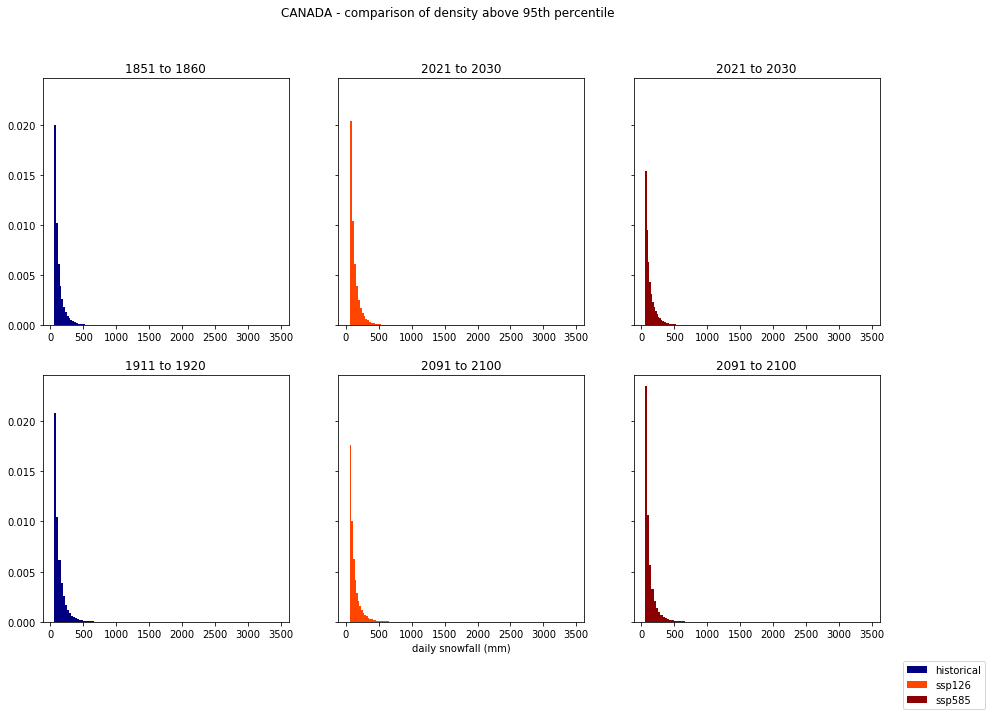

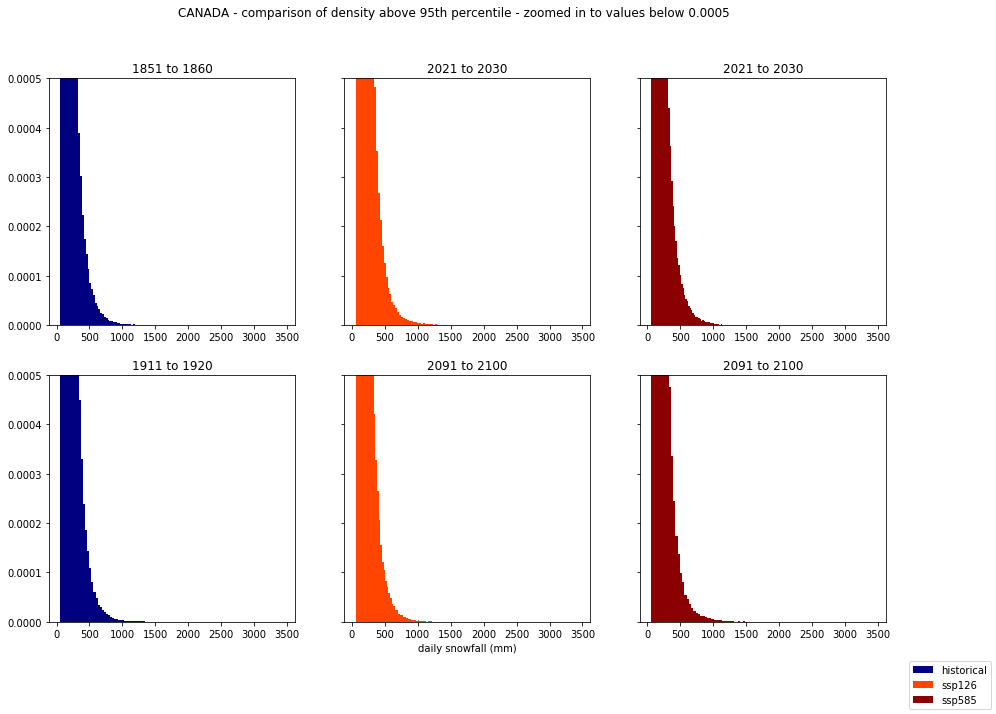

In [25]:
country_decade_comparison(cubelist_unweighted,canada_box,'djf','CANADA',False)

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 60265; latitude: 61; longitude: 123)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 61; longitude: 123)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 61; longitude: 123)>}
filter for djf season
approx_fresh_daily_snow_height / (1) (time: 14890; latitude: 61; longitude: 123)
     Dimension coordinates:
          time                            x                -              -
          latitude                        -                x              -
          longitude                       -                -              x
     Auxiliary coordinates:
          season                          x                -              -
          season_year                     x                -              -
     Attributes:
          contact: lennar

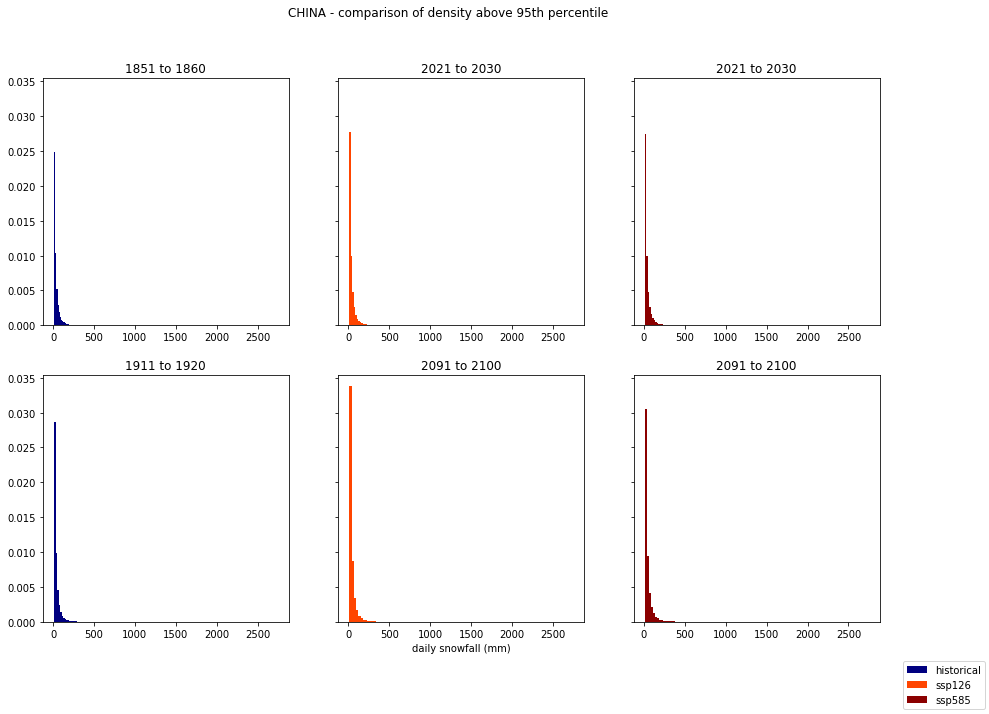

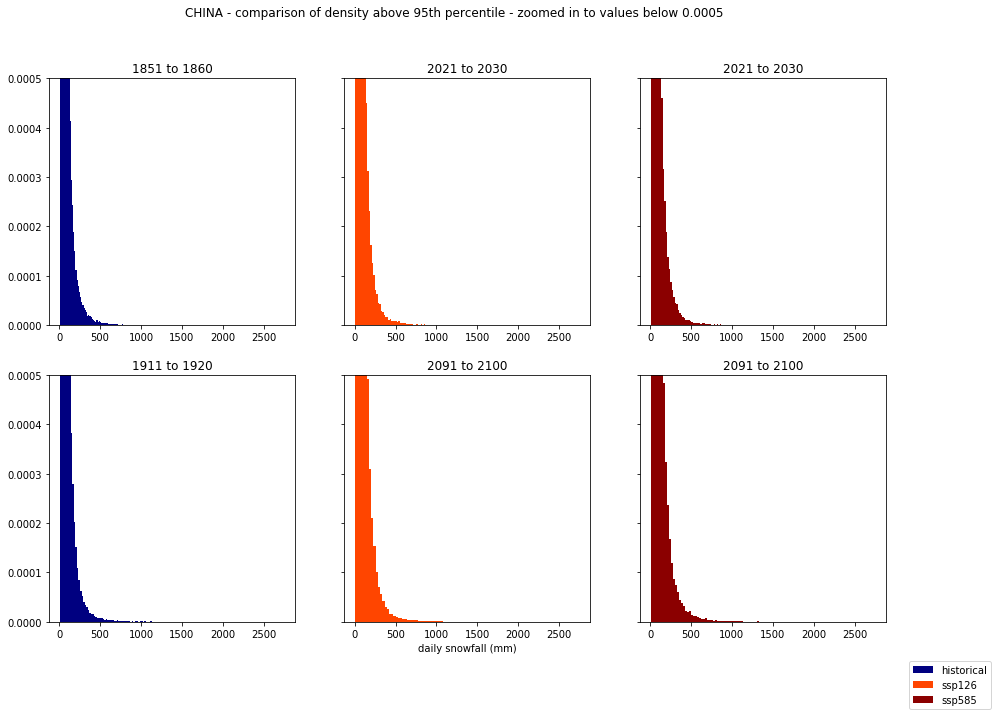

In [26]:
country_decade_comparison(cubelist_unweighted,china_box,'djf','CHINA',False)

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 60265; latitude: 17; longitude: 26)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 17; longitude: 26)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 17; longitude: 26)>}
filter for djf season
approx_fresh_daily_snow_height / (1) (time: 14890; latitude: 17; longitude: 26)
     Dimension coordinates:
          time                            x                -              -
          latitude                        -                x              -
          longitude                       -                -              x
     Auxiliary coordinates:
          season                          x                -              -
          season_year                     x                -              -
     Attributes:
          contact: lennart.qu

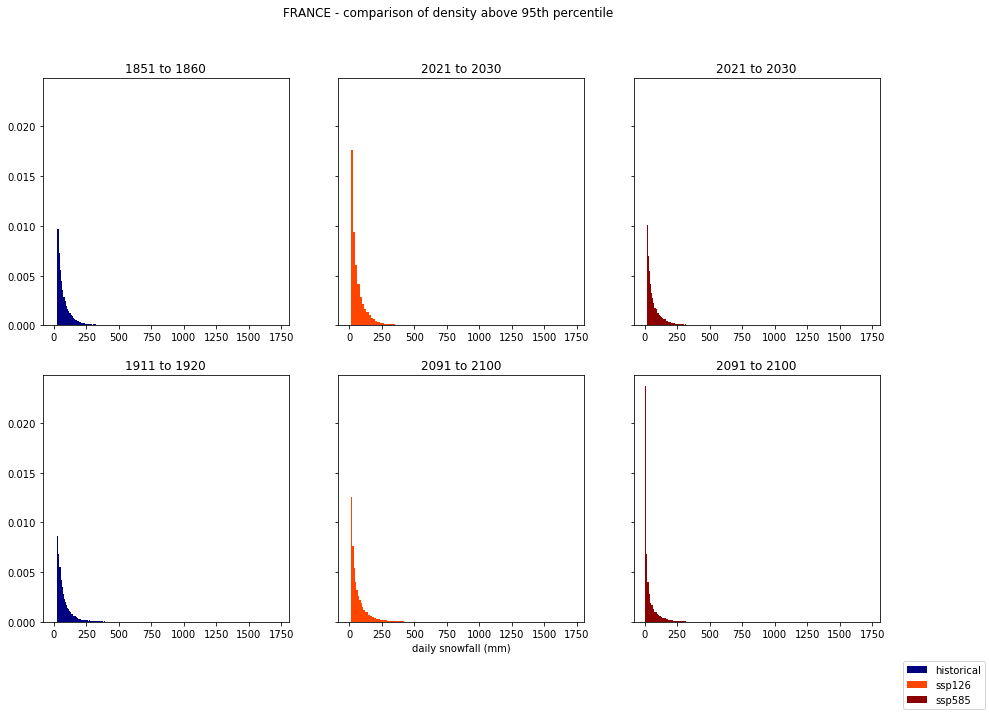

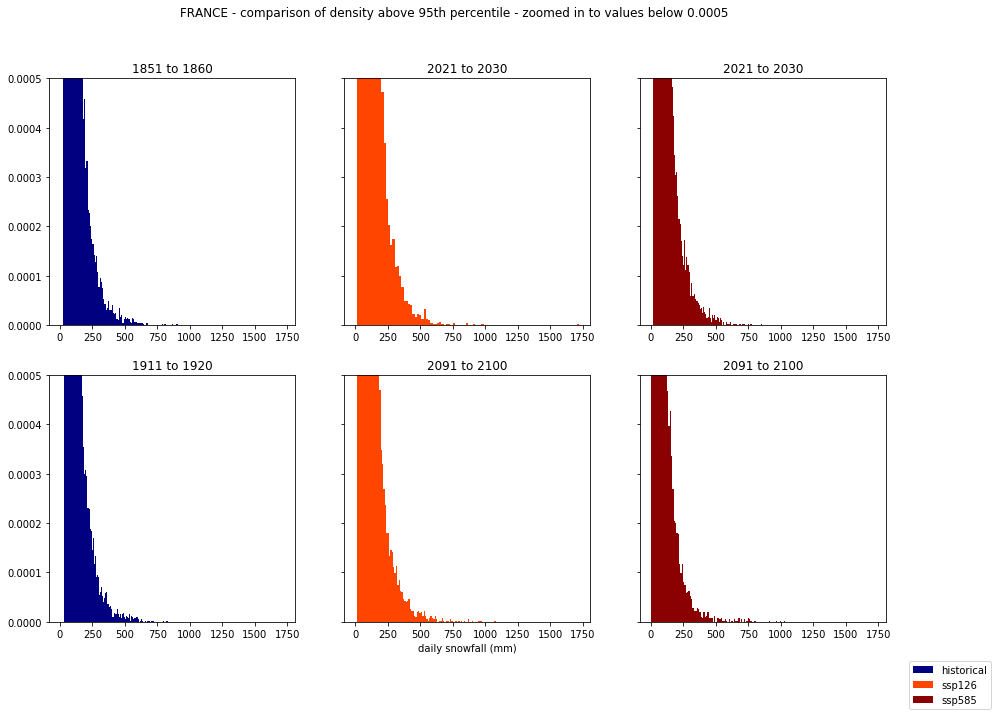

In [27]:
country_decade_comparison(cubelist_unweighted,france_box,'djf','FRANCE',False)

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 60265; latitude: 15; longitude: 18)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 15; longitude: 18)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 15; longitude: 18)>}
filter for djf season
approx_fresh_daily_snow_height / (1) (time: 14890; latitude: 15; longitude: 18)
     Dimension coordinates:
          time                            x                -              -
          latitude                        -                x              -
          longitude                       -                -              x
     Auxiliary coordinates:
          season                          x                -              -
          season_year                     x                -              -
     Attributes:
          contact: lennart.qu

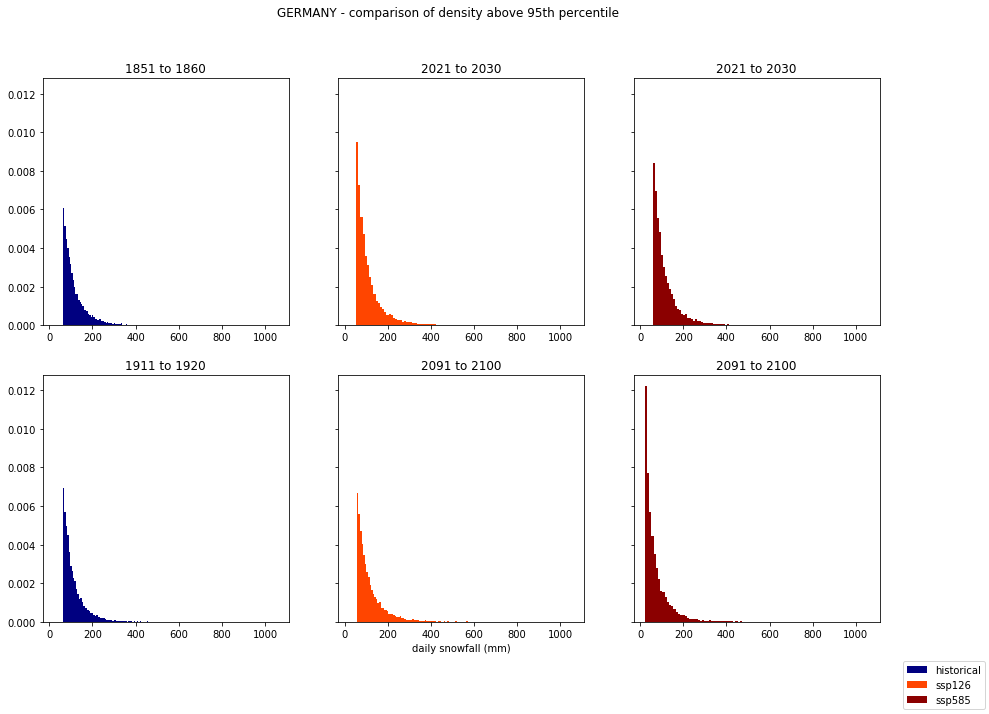

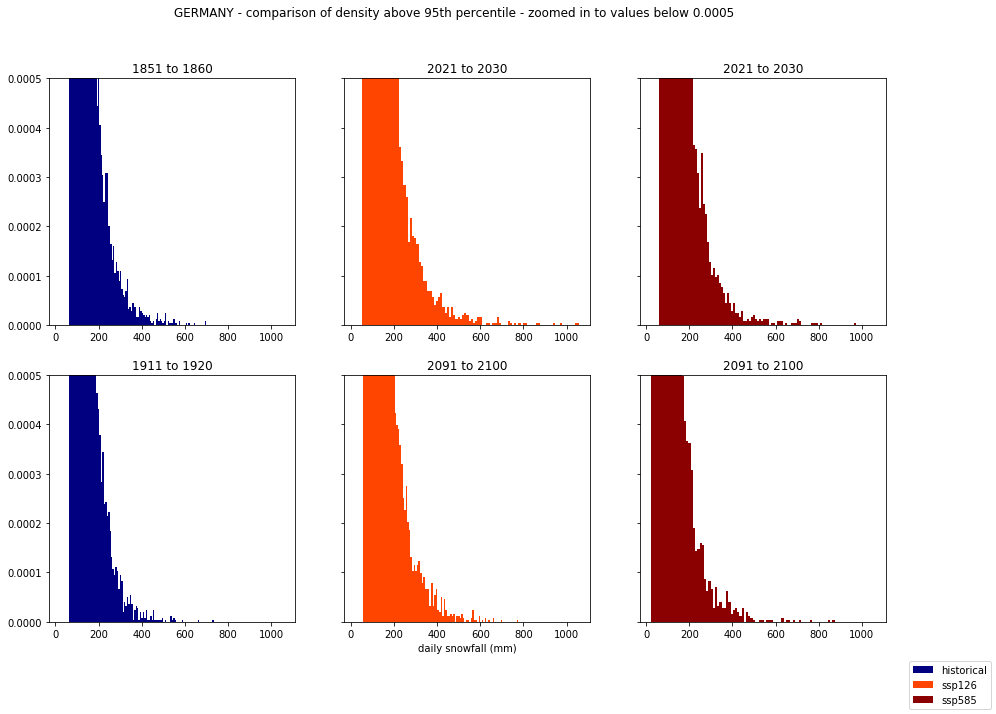

In [28]:
country_decade_comparison(cubelist_unweighted,germany_box,'djf','GERMANY',False)

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 60265; latitude: 31; longitude: 26)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 31; longitude: 26)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 31; longitude: 26)>}
filter for djf season
approx_fresh_daily_snow_height / (1) (time: 14890; latitude: 31; longitude: 26)
     Dimension coordinates:
          time                            x                -              -
          latitude                        -                x              -
          longitude                       -                -              x
     Auxiliary coordinates:
          season                          x                -              -
          season_year                     x                -              -
     Attributes:
          contact: lennart.qu

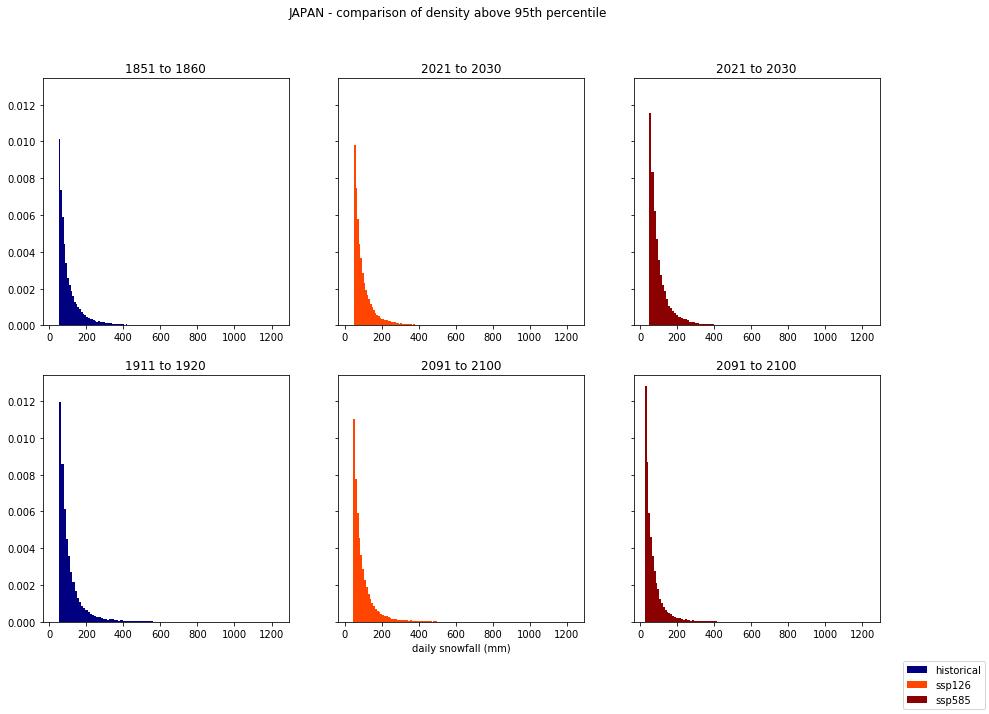

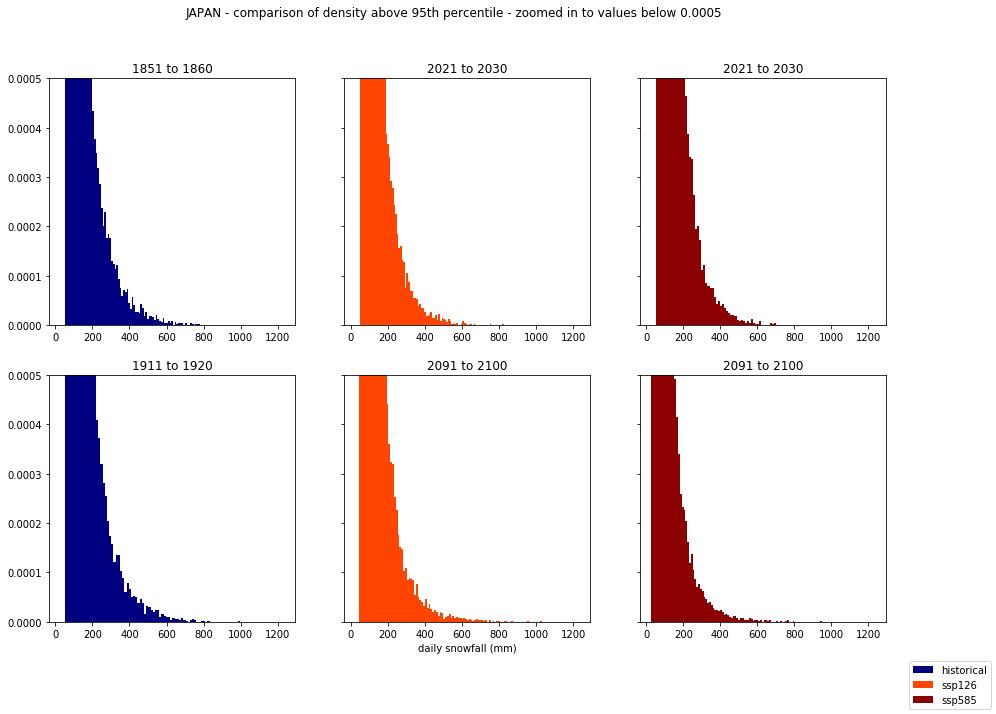

In [29]:
country_decade_comparison(cubelist_unweighted,japan_box,'djf','JAPAN',False)

{('ISIMIP3b-MPI-ESM-1-2-HR', 'historical'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 60265; latitude: 26; longitude: 52)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp126'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 26; longitude: 52)>, ('ISIMIP3b-MPI-ESM-1-2-HR', 'ssp585'): <iris 'Cube' of approx_fresh_daily_snow_height / (1) (time: 31411; latitude: 26; longitude: 52)>}
filter for djf season
approx_fresh_daily_snow_height / (1) (time: 14890; latitude: 26; longitude: 52)
     Dimension coordinates:
          time                            x                -              -
          latitude                        -                x              -
          longitude                       -                -              x
     Auxiliary coordinates:
          season                          x                -              -
          season_year                     x                -              -
     Attributes:
          contact: lennart.qu

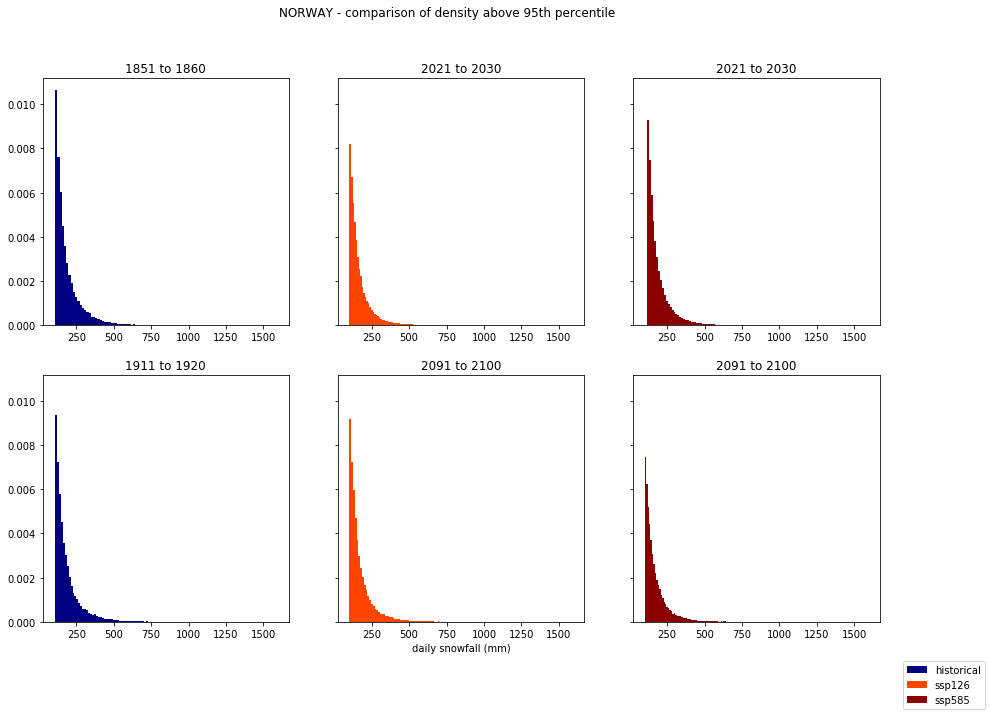

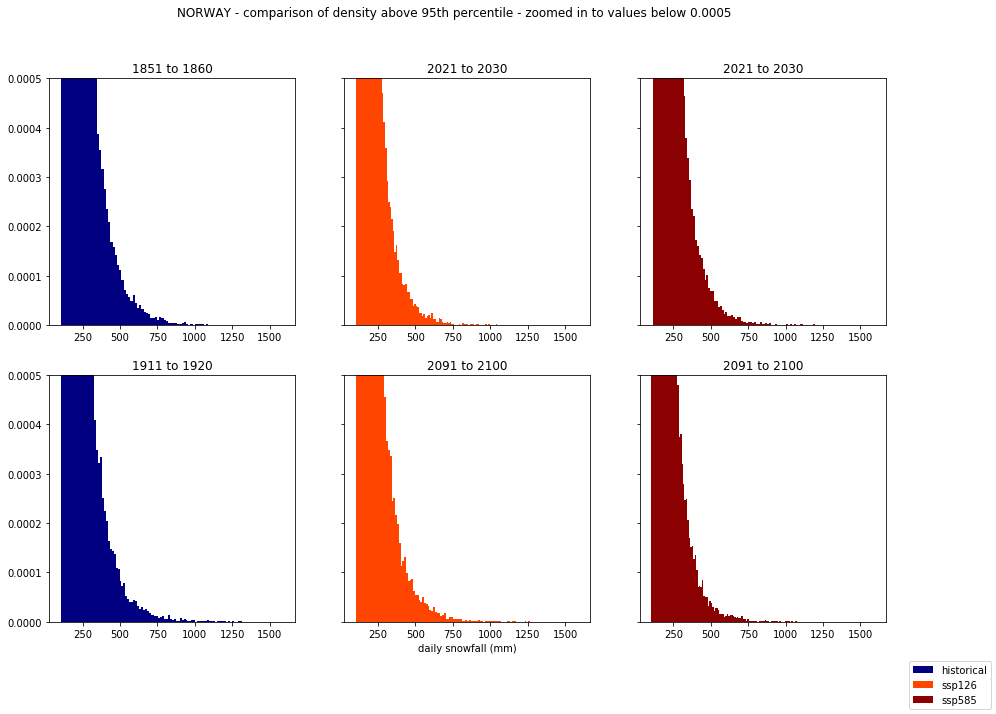

In [ ]:
country_decade_comparison(cubelist_unweighted,norway_box,'djf','NORWAY',False)

In [ ]:
country_decade_comparison(cubelist_unweighted,contingentUS_box,'djf','United States',False)

### Population weighted analysis

In [ ]:

country_decade_comparison(cubelist,canada_box,'djf','CANADA',True)



In [ ]:
country_decade_comparison(cubelist,china_box,'djf','CHINA',True)



In [ ]:
country_decade_comparison(cubelist,france_box,'djf','FRANCE',True)

In [ ]:

country_decade_comparison(cubelist,germany_box,'djf','GERMANY',True)

In [ ]:
country_decade_comparison(cubelist,japan_box,'djf','JAPAN',True)



In [ ]:
country_decade_comparison(cubelist,norway_box,'djf','NORWAY',True)



In [ ]:
country_decade_comparison(cubelist,contingentUS_box,'djf','UNITED STATES',True)



### Country analysis for winter season:

In [ ]:
print('German winter stats')

dictonary_cube_stats(germany_winter)
    
    


In [ ]:
print('China winter stats')
dictonary_cube_stats(china_winter)
    


In [ ]:
print('US winter stats')
dictonary_cube_stats(us_winter)

In [ ]:
global_seasons = {}
seasons = ['djf','mam','jja','son']
for i_key in tqdm(data_keys):
    for i_season in seasons:
        global_seasons[i_key,i_season] = prepare_season_stats(cubelist[i_key],i_season)
print(global_seasons)


### Northern hemisphere season stats -
averages of yearly mean / cell resp. yearly max/cell

In [ ]:

dictonary_global_stats (global_seasons)